In [5]:
import torch
import numpy as np
import pandas as pd
import os
from skimage import io
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
# convert data to torch.FloatTensor
transform =transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(100),transforms.ToTensor()]) 

In [6]:
class LoadDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
       
        landmarks = self.landmarks_frame.iloc[idx, 1:].values
        y = np.asarray([float(landmarks[0]),float(landmarks[1]),float(landmarks[2]),float(landmarks[3])])
        if self.transform:
            image = self.transform(image)
#            print(idx,"   ",y)
            y = torch.from_numpy(y).type(torch.FloatTensor)
        return [image,y]
data = LoadDataset("autoencode_flipkart.csv","/media/dhruv/Games/flipkart_round3/training")

In [7]:
batch_size=28
num_workers = 1

trainloader = torch.utils.data.DataLoader(data,num_workers=num_workers,batch_size=batch_size,shuffle=True)


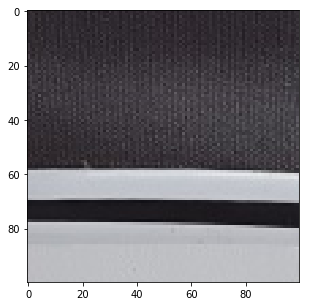

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img.transpose((1,2,0)))

In [9]:
img.shape

(3, 100, 100)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.enc = nn.Linear(30000,encoding_dim)
        ## decoder ##
        self.dec = nn.Linear(encoding_dim,30000)

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        x = F.sigmoid(self.dec(self.enc(x)))
        return x

# initialize the NN
encoding_dim = 1000
model = Autoencoder(encoding_dim).cuda()
print(model)

Autoencoder(
  (enc): Linear(in_features=30000, out_features=1000, bias=True)
  (dec): Linear(in_features=1000, out_features=30000, bias=True)
)


In [11]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [12]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in trainloader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images.cuda())
        # calculate the loss
        loss = criterion(outputs.cuda(), images.cuda())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(trainloader)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/home/dhruv/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.791145
Epoch: 2 	Training Loss: 1.667165
Epoch: 3 	Training Loss: 1.788188
Epoch: 4 	Training Loss: 1.644544
Epoch: 5 	Training Loss: 1.571972
Epoch: 6 	Training Loss: 1.584780
Epoch: 7 	Training Loss: 1.574222
Epoch: 8 	Training Loss: 1.527018
Epoch: 9 	Training Loss: 1.493203
Epoch: 10 	Training Loss: 1.464566
Epoch: 11 	Training Loss: 1.436669
Epoch: 12 	Training Loss: 1.404140
Epoch: 13 	Training Loss: 1.377914
Epoch: 14 	Training Loss: 1.347625
Epoch: 15 	Training Loss: 1.310214
Epoch: 16 	Training Loss: 1.269340
Epoch: 17 	Training Loss: 1.270559
Epoch: 18 	Training Loss: 1.203475
Epoch: 19 	Training Loss: 1.191808
Epoch: 20 	Training Loss: 1.119232
Epoch: 21 	Training Loss: 1.104032
Epoch: 22 	Training Loss: 1.087579
Epoch: 23 	Training Loss: 1.057817
Epoch: 24 	Training Loss: 1.038533
Epoch: 25 	Training Loss: 0.983152
Epoch: 26 	Training Loss: 0.963117
Epoch: 27 	Training Loss: 0.934456
Epoch: 28 	Training Loss: 0.897076
Epoch: 29 	Training Loss: 0.9

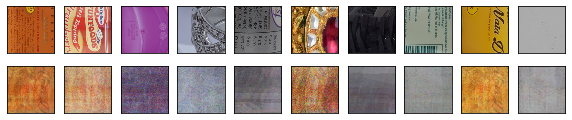

In [13]:
# obtain one batch of test images
dataiter = iter(trainloader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten.cuda())
# prep images for display
images = images.numpy()

# output is resized into a batch of images

output = output.view(batch_size, 3,100,100)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(10,2))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img.transpose((1,2,0))))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

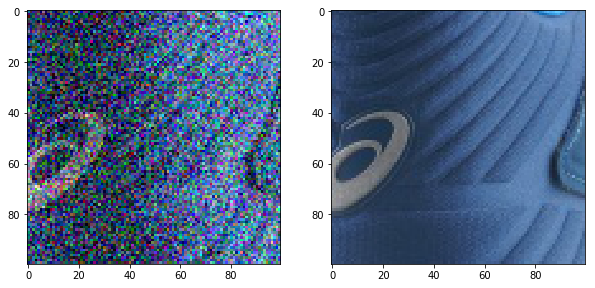

In [16]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
noisy_img = np.clip(img + 0.2*torch.randn(img.shape),0.,1.)
noisy_img = noisy_img.numpy()
noisy_img = noisy_img.transpose((1,2,0))
plt.figure(figsize = (10,5)) 

plt.subplot(121)
plt.imshow(noisy_img)

img = img.transpose(1,2,0)
plt.subplot(122)
plt.imshow(img)